**Credit Card Detection Pipeline**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE

In [1]:
dir = '../csv/'
fname = 'credit_card_fraud_sample_2019_Dec_100K'

In [4]:
df_BASE = pd.read_pickle(fname + '_eda.pkl')

In [7]:

print(df_BASE.info())

df_BASE.head()


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 38655 to 41847
Data columns (total 37 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   cc_num                     100000 non-null  int64         
 1   gender                     100000 non-null  int64         
 2   city                       100000 non-null  object        
 3   state                      100000 non-null  object        
 4   zip                        100000 non-null  int32         
 5   lat                        100000 non-null  float64       
 6   long                       100000 non-null  float64       
 7   city_pop                   100000 non-null  int64         
 8   job                        100000 non-null  object        
 9   dob                        100000 non-null  datetime64[ns]
 10  acct_num                   100000 non-null  int64         
 11  profile                    100000 non-null  object    

,cc_num,gender,city,state,zip,lat,long,city_pop,job,dob,...,age,age_group,cc_type,area_cat,distance,time_since_last_trans,job_cat,log_amt,log_time_since_last_trans,log_city_pop
38655,3510694985435665,0,sidney,NE,69162,41.138,-102.9856,7765,energy_manager,1941-05-26,...,78,senior,Unknown,urban,72.926922,0.000000,Management,1.144223,0.000000,8.957511
75696,3510694985435665,0,sidney,NE,69162,41.138,-102.9856,7765,energy_manager,1941-05-26,...,78,senior,Unknown,urban,125.293370,71.123889,Management,2.220290,4.278385,8.957511
32552,3510694985435665,0,sidney,NE,69162,41.138,-102.9856,7765,energy_manager,1941-05-26,...,78,senior,Unknown,urban,83.186257,0.829444,Management,1.324419,0.604012,8.957511
93986,3510694985435665,0,sidney,NE,69162,41.138,-102.9856,7765,energy_manager,1941-05-26,...,78,senior,Unknown,urban,49.663956,164.173333,Management,1.029619,5.106995,8.957511
70538,3510694985435665,0,sidney,NE,69162,41.138,-102.9856,7765,energy_manager,1941-05-26,...,78,senior,Unknown,urban,85.989781,103.780556,Management,4.805823,4.651868,8.957511


In [10]:
df_BASE.columns

Index(['cc_num', 'gender', 'city', 'state', 'zip', 'lat', 'long', 'city_pop',
       'job', 'dob', 'acct_num', 'profile', 'trans_num', 'trans_date',
       'trans_time', 'unix_time', 'category', 'amt', 'is_fraud', 'merchant',
       'merch_lat', 'merch_long', 'region', 'trans_day_of_week', 'is_weekend',
       'trans_hour', 'trans_time_segment', 'age', 'age_group', 'cc_type',
       'area_cat', 'distance', 'time_since_last_trans', 'job_cat', 'log_amt',
       'log_time_since_last_trans', 'log_city_pop'],
      dtype='object')

c:\Users\DCervin\.conda\envs\ds18_ml-proj1\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19942
           1       0.98      0.71      0.82        58

    accuracy                           1.00     20000
   macro avg       0.99      0.85      0.91     20000
weighted avg       1.00      1.00      1.00     20000

Confusion Matrix:
 [[19941     1]
 [   17    41]]
ROC AUC Score: 0.9899


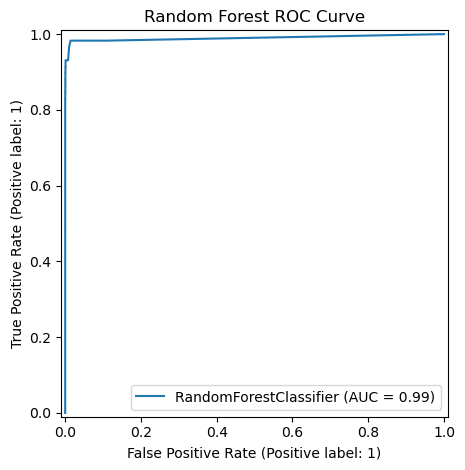

In [16]:


# Log transform skewed columns
#df['log_amt'] = np.log1p(df['amt'])
#df['log_city_pop'] = np.log1p(df['city_pop'])
#df['log_time_since_last_trans'] = np.log1p(df['time_since_last_trans'])

# Encode categorical variables
df_encoded = df_BASE.copy()
categorical_cols = df_BASE.select_dtypes(include='object').columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

# Prepare data
X = df_encoded.drop(columns=['is_fraud', 'cc_num', 'acct_num', 'trans_num', 
    'profile', 'trans_date', 'trans_time', 'dob'])
y = df_encoded['is_fraud']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_resampled, y_resampled)

# Predict
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# ROC Curve
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest ROC Curve")
plt.tight_layout()
plt.show()